<a href="https://colab.research.google.com/github/matand380/DNN_final_project_2024/blob/main/DNN_final_project_2024%2Btl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning - Final Project** 🖥

## Team Information
- **Course:** Introduction to Deep Learning

- **Semester:** Fall 2024

- **Lectrurer:** Dr. Moshe Butman

- **Institution:** The College of Management Academic Studies

- **Team Members:** Eviatar Didon 313205387, Matan Drabkin 201416690

## Project Overview

### Objective

This project centers around the application of deep learning techniques to classify chest X-ray images into distinct categories,

with a specific emphasis on differentiating between healthy cases and those diagnosed with pneumonia.

The dataset for training and evaluation includes a total of 5863 X-ray images, categorized as follows:

- A. **Healthy**
- B. **Pneumonia**
  - Bacterial Pneumonia
  - Viral Pneumonia



# Kaggle Dataset Downloading and Unzipping

### Prerequisites

Ensure that the necessary packages (`kaggle`) are installed before running the code. Use the following command to install the `kaggle` package:

In [ ]:
!pip install kaggle

### Uploading Kaggle API Key

Use the file picker to upload your Kaggle API key:


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


### Move API Key to the Right Directory

After uploading the API key, please ensure that Kaggle can use the API key for authentication.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download and Unzip Kaggle Dataset

download the Chest X-ray Pneumonia dataset and unzip it in the Colab environment:

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

drive_path = '/content/gdrive/My Drive/Colab Notebooks/DNN_final_project_2024'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

# Specify the path to the unzipped dataset directory in Google Drive
dataset_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray'

# Check if the dataset directory exists
if os.path.exists(dataset_dir):
    # Now you can access your dataset in the 'dataset_dir' directory
    print("Dataset directory exists.")
    print("You can use 'dataset_dir' for further processing.")
else:
    print("Dataset directory does not exist. Please provide the correct path.")



Dataset directory exists.
You can use 'dataset_dir' for further processing.


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

healthy_image_path = '/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
viral_pneumonia_image_path = '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'
bacterial_pneumonia_image_path = '/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'

healthy_image = cv2.imread(healthy_image_path)
viral_pneumonia_image = cv2.imread(viral_pneumonia_image_path)
bacterial_pneumonia_image = cv2.imread(bacterial_pneumonia_image_path)

# Convert BGR images to RGB
healthy_image = cv2.cvtColor(healthy_image, cv2.COLOR_BGR2RGB)
viral_pneumonia_image = cv2.cvtColor(viral_pneumonia_image, cv2.COLOR_BGR2RGB)
bacterial_pneumonia_image = cv2.cvtColor(bacterial_pneumonia_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(healthy_image)
plt.title('Healthy')

plt.subplot(1, 3, 2)
plt.imshow(viral_pneumonia_image)
plt.title('Viral Pneumonia')

plt.subplot(1, 3, 3)
plt.imshow(bacterial_pneumonia_image)
plt.title('Bacterial Pneumonia')

plt.show()


# Binary classification - Healthy vs Pneumonia

## Preprocessing - Data augmentation and normalization

In [ ]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
train_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray/val'
test_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

## Reorganization of the data

In the original data there's only 16 samples for the validation set. At the first training we got overfitting on the validation so we reorganize the samples in order to get more balanced data

In [ ]:
import random

# We load all file paths in the training and validation directories and combine them
all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

random.shuffle(all_files) ## check

labels = [os.path.basename(os.path.dirname(file)) for file in all_files]

# Split the into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary',

)

num_val_images = len(val_files)
print(f"Number of images in the validation set: {num_val_images}")

num_train_images = len(train_files)
print(f"Number of images in the validation set: {num_train_images}")



Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.
Number of images in the validation set: 1047
Number of images in the validation set: 4185


## Build the model and train it


- we tried setting the lreaning rate to 0.01 but we got worse results than 0.
001 (which is the default for Adam optimizer)
- we minimized the shapes of the input from 224 x 224 to 64 x 64 and got better results.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #used defualt lr = 0.001

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 82944)            

In [ ]:

from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.7498

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 100s 748ms/step - loss: 0.5353 - accuracy: 0.7498 - val_loss: 0.4649 - val_accuracy: 0.7784
Epoch 2/10
131/131 [==============================] - 95s 725ms/step - loss: 0.3980 - accuracy: 0.8227 - val_loss: 0.3362 - val_accuracy: 0.8777
Epoch 3/10
131/131 [==============================] - 88s 675ms/step - loss: 0.3482 - accuracy: 0.8447 - val_loss: 0.3071 - val_accuracy: 0.8768
Epoch 4/10
131/131 [==============================] - 89s 681ms/step - loss: 0.3386 - accuracy: 0.8504 - val_loss: 0.2736 - val_accuracy: 0.8892
Epoch 5/10
131/131 [==============================] - 90s 685ms/step - loss: 0.3188 - accuracy: 0.8628 - val_loss: 0.2457 - val_accuracy: 0.9179
Epoch 6/10
131/131 [==============================] - 86s 653ms/step - loss: 0.2995 - accuracy: 0.8683 - val_loss: 0.2855 - val_accuracy: 0.9093
Epoch 7/10
131/131 [==============================] - 90s 688ms/step - loss: 0.2887 - accuracy: 0.8805 - val_loss: 0.2121 - val_accuracy: 0.

In [ ]:
model.save(f'{drive_path}/binary_model.h5')

In [ ]:
print("Training Accuracy:", round(history.history['accuracy'][-1], 3))
print("Training Loss:", round(history.history['loss'][-1], 3))
print("Validation Accuracy:", round(history.history['val_accuracy'][-1], 3))
print("Validation Loss:", round(history.history['val_loss'][-1], 3))

Training Accuracy: 0.884
Training Loss: 0.29
Validation Accuracy: 0.933
Validation Loss: 0.198


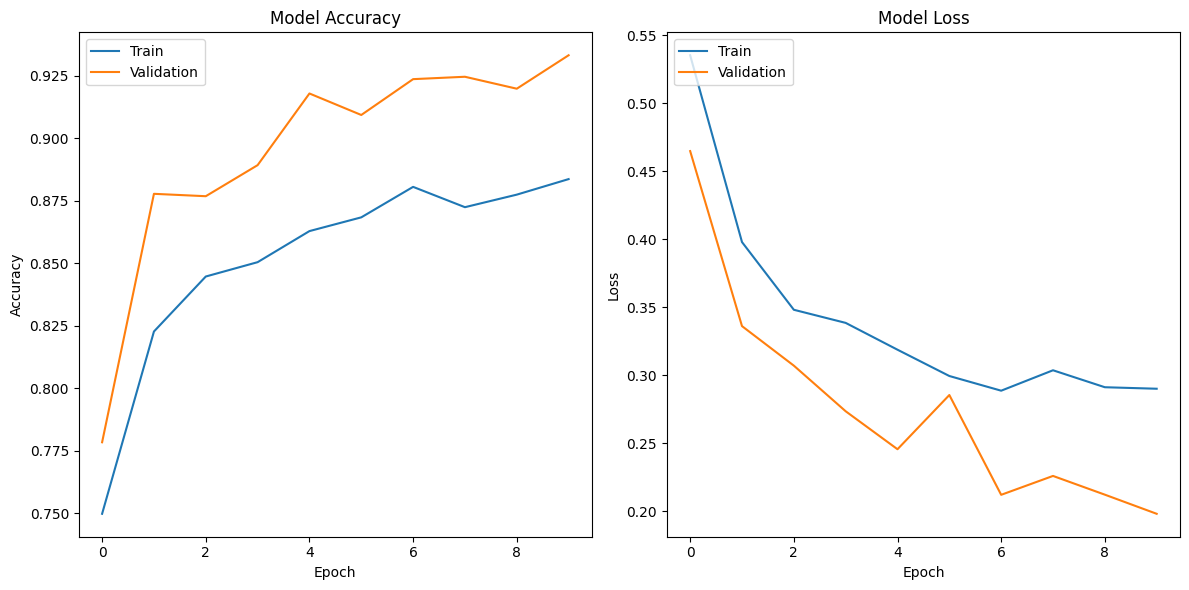

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


### Evaluate the model

In [ ]:
from keras.models import load_model

binary_model = load_model(f'{drive_path}/binary_model.h5')
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluation_result = model.evaluate(test_generator, steps=len(test_generator))

test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


20/20 [==============================] - 8s 393ms/step - loss: 0.3794 - accuracy: 0.8141
Test Loss: 0.3794
Test Accuracy: 81.41%


20/20 [==============================] - 9s 431ms/step
0.594551282051282


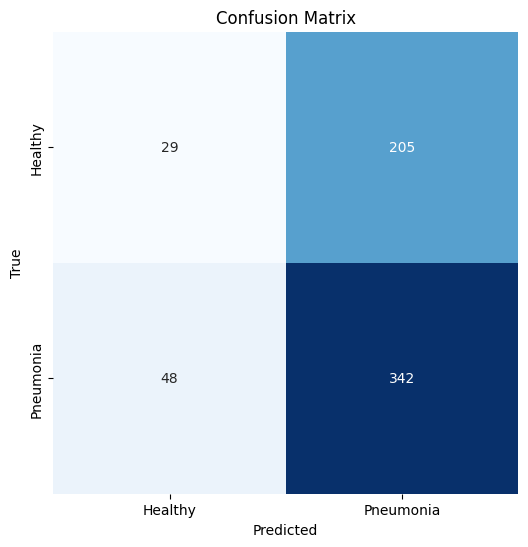

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Make predictions on the test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.3)

# Get true labels from the test generator
y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

# Define class labels
class_labels = ['Healthy', 'Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = model.predict(test_generator)
pred=[]
for prediction in predictions:
  pred.append(prediction[0])

true_labels = test_generator.classes

success = 0
for i in range (len(pred)):
  if (pred[i] < 0.5 and true_labels[i] == 0) or (pred[i] > 0.5 and true_labels[i] == 1):
    success +=1

rate = success / len(pred)
print("Success rate: ",rate)

20/20 [==============================] - 8s 407ms/step
Success rate:  0.5769230769230769


Sample 1: Prediction = [ True], Actual Label = 0
Sample 2: Prediction = [ True], Actual Label = 0
Sample 3: Prediction = [ True], Actual Label = 0
Sample 4: Prediction = [ True], Actual Label = 0
Sample 5: Prediction = [ True], Actual Label = 0
Sample 6: Prediction = [ True], Actual Label = 0
Sample 7: Prediction = [ True], Actual Label = 0
Sample 8: Prediction = [ True], Actual Label = 0
Sample 9: Prediction = [False], Actual Label = 0
Sample 10: Prediction = [ True], Actual Label = 0


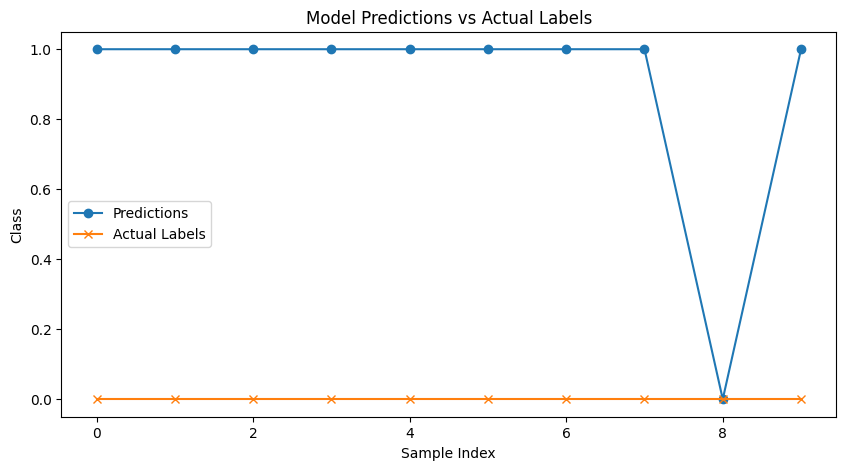

In [ ]:
import matplotlib.pyplot as plt


for i in range(10):
    prediction = y_pred[i]
    actual_label = y_true[i]

    print(f"Sample {i + 1}: Prediction = {prediction}, Actual Label = {actual_label}")



# Plotting the predictions and actual labels
plt.figure(figsize=(10, 5))
plt.plot(range(10), y_pred[:10], label='Predictions', marker='o')
plt.plot(range(10), y_true[:10], label='Actual Labels', marker='x')
plt.title('Model Predictions vs Actual Labels')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()


# Multi-class classification

## Modify data preparation

In [ ]:
# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Transfer learning model

In [ ]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras import layers, models
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
tl_model = base_model.output
tl_model=GlobalAveragePooling2D()(tl_model)
tl_model=Dense(units=1024, activation='relu')(tl_model)
tl_model=Dense(units=1024, activation='relu')(tl_model)
tl_model=Dense(units=512, activation='relu')(tl_model)
preds = Dense(1, activation='sigmoid')(tl_model)

In [ ]:
final_model= Model(inputs=base_model.input,outputs=preds)

In [ ]:
for layer in final_model.layers[:-4]:
  layer.trainable=False

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
import random
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
train_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray/val'
test_dir = '/content/gdrive/MyDrive/Colab Notebooks/chest_xray/test'

# We load all file paths in the training and validation directories and combine them
all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

random.shuffle(all_files) ## check

labels = [os.path.basename(os.path.dirname(file)) for file in all_files]

# Split the into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

train_datagen_tl = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen_tl.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_datagen_tl = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen_tl.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

test_datagen_tl = ImageDataGenerator(preprocessing_function=preprocess_input)
# Test generator for evaluation
test_generator = test_datagen_tl.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
final_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizati  (None, None, None, 32)    128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, None, None, 32)    288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, None, None, 32)    128 

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/best_model_tl.h5', save_best_only=True)

spe = train_generator.n // train_generator.batch_size
spe_val = val_generator.n // val_generator.batch_size
history_tl = final_model.fit(train_generator, steps_per_epoch=spe, epochs=5, validation_data=val_generator, validation_steps=spe_val, callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
130/130 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9822

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 70s 541ms/step - loss: 0.0590 - accuracy: 0.9822 - val_loss: 0.0461 - val_accuracy: 0.9854
Epoch 2/5
130/130 [==============================] - 83s 642ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.0420 - val_accuracy: 0.9844
Epoch 3/5
130/130 [==============================] - 69s 530ms/step - loss: 0.0420 - accuracy: 0.9868 - val_loss: 0.2092 - val_accuracy: 0.9619
Epoch 4/5
130/130 [==============================] - 75s 576ms/step - loss: 0.0673 - accuracy: 0.9793 - val_loss: 0.0652 - val_accuracy: 0.9814
Epoch 5/5
130/130 [==============================] - 69s 530ms/step - loss: 0.0332 - accuracy: 0.9889 - val_loss: 0.0482 - val_accuracy: 0.9834


39/39 [==============================] - 11s 249ms/step
0.5689102564102564


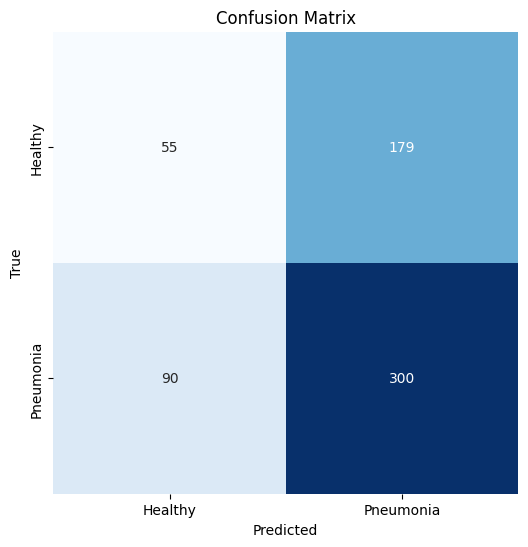

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Make predictions on the test set
y_pred_prob = model_tl.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Get true labels from the test generator
y_true = test_generator.classes
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)

# Define class labels
class_labels = ['Healthy', 'Pneumonia']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from keras.models import load_model

model_tl = load_model(f'{drive_path}/best_model_tl.h5')
model_tl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluation_result = model_tl.evaluate(test_generator, steps=(test_generator.n // test_generator.batch_size))

test_loss = evaluation_result[0]
test_accuracy = evaluation_result[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


39/39 [==============================] - 8s 189ms/step - loss: 0.9403 - accuracy: 0.8478
Test Loss: 0.9403
Test Accuracy: 84.78%
